In [137]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [138]:
cyclists_data = pd.read_csv("dataset/cyclists.csv",index_col=0)
races_data = pd.read_csv("dataset/races.csv",index_col=0)
cyclists_data.info()
cyclists_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6134 non-null   object 
 1   birth_year   6121 non-null   float64
 2   weight       3078 non-null   float64
 3   height       3143 non-null   float64
 4   nationality  6133 non-null   object 
 5   cyclist_id   6134 non-null   object 
dtypes: float64(3), object(3)
memory usage: 335.5+ KB


,name,birth_year,weight,height,nationality,cyclist_id
0,Bruno Surra,1964.0,NaN,NaN,Italy,bruno-surra
1,Gérard Rué,1965.0,74.0,182.0,France,gerard-rue
2,Jan Maas,1996.0,69.0,189.0,Netherlands,jan-maas
3,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium,nathan-van-hooydonck
4,José Félix Parra,1997.0,55.0,171.0,Spain,jose-felix-parra


In [139]:
# models cannot take into account parameters like the name -> discrminative and senseless
cyclists_data_imp_mean = cyclists_data.drop(columns=['name'])

In [140]:
races_data.info()
races_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist_age          589752 non-null  float64
 12  is_tarmac            589865 non-null  bool   
 13  is_cobbled           589865 non-null  bool   
 14  is_gravel            589865 non-null  bool   
 15  cyclist_team         4

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,cyclist_id
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0,sean-kelly
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,27.0,True,False,False,norway-1987,0.0,gerrie-knetemann
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,24.0,True,False,False,NaN,0.0,rene-bittinger
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,30.0,True,False,False,navigare-blue-storm-1993,0.0,joseph-bruyere
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,27.0,True,False,False,spain-1991,0.0,sven-ake-nilsson


# 1. Data Processing

## 1.1 Categorical variables,  normalizing and standarizing

In [141]:
# Define function to categorize 'position'
# This will later be the label for our classifiers
def categorize_position(pos):
    if pos <= 3:
        return "Podium"
    elif pos <= 20:
        return "Top20"
    elif pos <= 50:
        return "Top50"
    elif pos <= 100:
        return "Top100"
    else:
        return "Remaining"

# Apply categorization
races_data["position_category"] = races_data["position"].apply(categorize_position)

# Check distribution of categories
position_distribution = races_data["position_category"].value_counts(normalize=True) * 100

position_distribution


position_category
Remaining    31.518737
Top100       31.315301
Top50        20.382121
Top20        13.207429
Podium        3.576412
Name: proportion, dtype: float64

In [142]:
# Identify float64 columns
float_cols = races_data.select_dtypes(include=['float64']).columns

# Convert float64 to int, handling NaN values
for col in float_cols:
    if col in ['points', 'climb_total', 'uci_points', 'length', 'cyclist_age', 'delta']:  # Specify columns that should be int
        races_data[col] = races_data[col].fillna(0).astype(int)  # Replace NaN with 0 before conversion

# Check the new data types
print(races_data.dtypes)

_url                    object
name                    object
points                   int64
uci_points               int64
length                   int64
climb_total              int64
profile                float64
startlist_quality        int64
average_temperature    float64
date                    object
position                 int64
cyclist_age              int64
is_tarmac                 bool
is_cobbled                bool
is_gravel                 bool
cyclist_team            object
delta                    int64
cyclist_id              object
position_category       object
dtype: object


In [143]:
# Nationality from object to category
cyclists_data['nationality'] = cyclists_data['nationality'].astype('category')

# Convert the 'cyclist_team' column to category type
races_data['cyclist_team'] = races_data['cyclist_team'].astype('category')
# Convert the 'cyclists_age' column to int32 type
races_data['cyclist_age'] = races_data['cyclist_age'].astype('int32')

# Correcting some type castings that are unnecesary in races dataset
races_data['points'] = races_data['points'].astype(int)
races_data['length'] = races_data['length'].astype(int)
races_data['delta'] = races_data['delta'].astype(int)
races_data['cyclist_age'] = races_data['cyclist_age'].astype(int)
races_data['cyclist_id'] = races_data['cyclist_id'].astype('string')

# Split _url into into ['race_name', 'year', 'stage'] by /
races_data[['race_name', 'year', 'stage']] = races_data['_url'].str.split('/', expand=True)
races_data = races_data.drop(columns=['_url'])
#races_data['stage'] = races_data['stage'].astype('string')
races_data['year'] = races_data['year'].astype(int)

# Now we have 2 columns with race_name
races_data = races_data.drop(columns=['name'])

# Extract month from date and remove date
# Year already from _url and we discard day and hour
races_data['date'] = pd.to_datetime(races_data['date'])
races_data['month'] = races_data['date'].dt.month
races_data = races_data.drop(columns=['date'])

# climb_total and profile are highly correlated, so we combine them
races_data['aug_profile'] = np.where(
    races_data['climb_total'].notna() & races_data['profile'].notna(),
    races_data['climb_total'] / races_data['climb_total'].max() + races_data['profile'],
    np.nan  # Assign NaN if either column is still missing
)
races_data = races_data.drop(columns=['climb_total'])
races_data = races_data.drop(columns=['profile'])

In [144]:
# Encode categorical values of races df
categorical_cols = ['cyclist_team', 'race_name', 'stage']
encoder = LabelEncoder()

for col in categorical_cols:
    races_data[col] = encoder.fit_transform(races_data[col])
    
cyclists_data['nationality'] = encoder.fit_transform(cyclists_data['nationality'])

In [145]:
# Always: is_tarmac= true, is_cobbled=False, is_gravel=False
races_data = races_data.drop(columns=['is_tarmac', 'is_cobbled', 'is_gravel'])

## 1.2 Managing missing values

In [146]:
cyclists_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         6134 non-null   object 
 1   birth_year   6121 non-null   float64
 2   weight       3078 non-null   float64
 3   height       3143 non-null   float64
 4   nationality  6134 non-null   int64  
 5   cyclist_id   6134 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 335.5+ KB


In [147]:
# We dont need name with id
cyclists_data = cyclists_data.drop(columns=['name'])

In [148]:
# Checkimg (and removing if there were any) duplicates in both datasets
duplicated_races = races_data[races_data.duplicated(keep=False)]
print(duplicated_races.shape)

duplicated_cyclists = cyclists_data[cyclists_data.duplicated(keep=False)]
print(duplicated_cyclists.shape)

(0, 16)
(0, 5)


In [149]:
print(cyclists_data.shape)
print("Number of null in cyclists dataset")
print("----------------------------------")
print(cyclists_data.isnull().sum(),'\n')

print("Percentage of null in cyclists dataset")
print("----------------------------------")
print(round(cyclists_data.isnull().sum()*100/cyclists_data.shape[0],2).astype(str) + '%')

(6134, 5)
Number of null in cyclists dataset
----------------------------------
birth_year       13
weight         3056
height         2991
nationality       0
cyclist_id        0
dtype: int64 

Percentage of null in cyclists dataset
----------------------------------
birth_year      0.21%
weight         49.82%
height         48.76%
nationality      0.0%
cyclist_id       0.0%
dtype: object


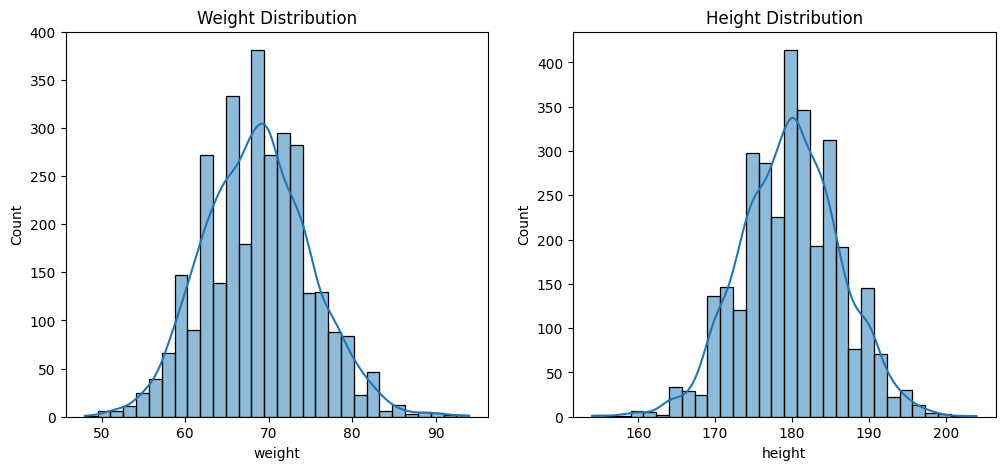

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(cyclists_data['weight'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Weight Distribution')

sns.histplot(cyclists_data['height'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Height Distribution')

plt.show()

In [151]:
cyclists_data_imp_mean = cyclists_data.copy()

cyclists_data_imp_mean['birth_year_missing'] = np.where(cyclists_data_imp_mean['birth_year'].isna(), 1, 0)
cyclists_data_imp_mean['weight_missing'] = np.where(cyclists_data_imp_mean['weight'].isna(), 1, 0)

cyclists_data_imp_mean['birth_year'].fillna(cyclists_data_imp_mean['birth_year'].mean(), inplace=True)
cyclists_data_imp_mean['weight'].fillna(cyclists_data_imp_mean['weight'].mean(), inplace=True)
cyclists_data_imp_mean['height'].fillna(cyclists_data_imp_mean['height'].mean(), inplace=True)

# cyclists_data_imp_median = cyclists_data.copy()
# cyclists_data_imp_median['birth_year'].fillna(cyclists_data_imp_median['birth_year'].mean(), inplace=True)
# cyclists_data_imp_median['weight'].fillna(cyclists_data_imp_median['weight'].mean(), inplace=True)
# cyclists_data_imp_median['height'].fillna(cyclists_data_imp_median['height'].mean(), inplace=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_12576\2599490975.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cyclists_data_imp_mean['birth_year'].fillna(cyclists_data_imp_mean['birth_year'].mean(), inplace=True)
C:\Users\angel\AppData\Local\Temp\ipykernel_12576\2599490975.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

In [152]:
print("Correlation between columns")
print("----------------------------------")
print('Weight-Height\t',cyclists_data['weight'].corr(cyclists_data['height']))
print('Weight-Birth Year\t',cyclists_data['weight'].corr(cyclists_data['birth_year']))
print('Height-Birth Year\t',cyclists_data['height'].corr(cyclists_data['birth_year']))

Correlation between columns
----------------------------------
Weight-Height	 0.7207320842827667
Weight-Birth Year	 -0.10424159211777138
Height-Birth Year	 0.15425242554298202


In [153]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# imp_iter = IterativeImputer(random_state=0)
# cyclists_data_name, cyclists_data_no_name = cyclists_data.iloc[:,-1:], cyclists_data.iloc[:,:-1]
# cyclists_data_no_name = pd.DataFrame(imp_iter.fit_transform(cyclists_data_no_name),columns=cyclists_data_no_name.columns)
# cyclists_data_no_name['cyclist_id'] = cyclists_data_name
# cyclists_data_imp_iter = cyclists_data_no_name.copy()
# cyclists_data_imp_iter

In [154]:
cyclists_data

,birth_year,weight,height,nationality,cyclist_id
0,1964.0,NaN,NaN,34,bruno-surra
1,1965.0,74.0,182.0,24,gerard-rue
2,1996.0,69.0,189.0,46,jan-maas
3,1995.0,78.0,192.0,7,nathan-van-hooydonck
4,1997.0,55.0,171.0,60,jose-felix-parra
...,...,...,...,...,...
6129,1966.0,NaN,NaN,60,juan-jose-martinez-diaz
6130,1998.0,75.0,188.0,60,inigo-elosegui
6131,1973.0,NaN,NaN,34,paolo-alberati
6132,1985.0,58.0,170.0,69,jackson-rodriguez


In [155]:
races_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589865 entries, 0 to 589864
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   points               589865 non-null  int64  
 1   uci_points           589865 non-null  int64  
 2   length               589865 non-null  int64  
 3   startlist_quality    589865 non-null  int64  
 4   average_temperature  29933 non-null   float64
 5   position             589865 non-null  int64  
 6   cyclist_age          589865 non-null  int64  
 7   cyclist_team         589865 non-null  int64  
 8   delta                589865 non-null  int64  
 9   cyclist_id           589865 non-null  string 
 10  position_category    589865 non-null  object 
 11  race_name            589865 non-null  int64  
 12  year                 589865 non-null  int64  
 13  stage                589865 non-null  int64  
 14  month                589865 non-null  int32  
 15  aug_profile          4

In [156]:
print(races_data.shape)
print("Number of null in races dataset")
print("----------------------------------")
print(races_data.isnull().sum(),'\n')

print("Percentage of null in races dataset")
print("----------------------------------")
print(round(races_data.isnull().sum()*100/races_data.shape[0],2).astype(str) + '%')

(589865, 16)
Number of null in races dataset
----------------------------------
points                      0
uci_points                  0
length                      0
startlist_quality           0
average_temperature    559932
position                    0
cyclist_age                 0
cyclist_team                0
delta                       0
cyclist_id                  0
position_category           0
race_name                   0
year                        0
stage                       0
month                       0
aug_profile            148194
dtype: int64 

Percentage of null in races dataset
----------------------------------
points                   0.0%
uci_points               0.0%
length                   0.0%
startlist_quality        0.0%
average_temperature    94.93%
position                 0.0%
cyclist_age              0.0%
cyclist_team             0.0%
delta                    0.0%
cyclist_id               0.0%
position_category        0.0%
race_name               

In [157]:
# It has almost 100% of data loss, so we decided to drop it
races_data = races_data.drop(columns=['average_temperature'])

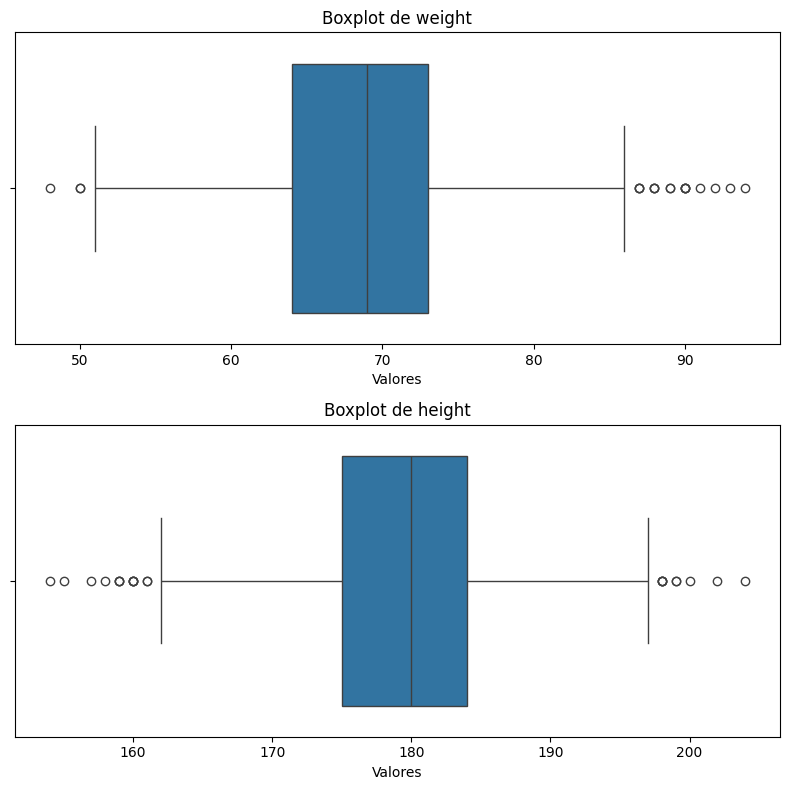

In [158]:
# Checking the columns on the cyclists dataset with the most null values
columns_to_plot = ['weight', 'height']

num_columns = len(columns_to_plot)
fig, axes = plt.subplots(num_columns, 1, figsize=(8, num_columns * 4))

for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=cyclists_data, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_xlabel('Valores')

plt.tight_layout() 
plt.show()

In [159]:
races_data = races_data.rename(columns={"name": "race_name"})

merged_data = races_data.merge(cyclists_data_imp_mean, on="cyclist_id", how="left")

#it was necessary for the merge but is not for the model training
merged_data = merged_data.drop(columns=['cyclist_id'])

# Mostrar las primeras filas para verificar
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   points              589865 non-null  int64  
 1   uci_points          589865 non-null  int64  
 2   length              589865 non-null  int64  
 3   startlist_quality   589865 non-null  int64  
 4   position            589865 non-null  int64  
 5   cyclist_age         589865 non-null  int64  
 6   cyclist_team        589865 non-null  int64  
 7   delta               589865 non-null  int64  
 8   position_category   589865 non-null  object 
 9   race_name           589865 non-null  int64  
 10  year                589865 non-null  int64  
 11  stage               589865 non-null  int64  
 12  month               589865 non-null  int32  
 13  aug_profile         441671 non-null  float64
 14  birth_year          589865 non-null  float64
 15  weight              589865 non-nul

In [160]:
merged_data.head()

,points,uci_points,length,startlist_quality,position,cyclist_age,cyclist_team,delta,position_category,race_name,year,stage,month,aug_profile,birth_year,weight,height,nationality,birth_year_missing,weight_missing
0,100,0,162000,1241,0,22,89,0,Podium,20,1978,44,7,1.157872,1956.0,77.000000,180.000000,32,0,0
1,100,0,162000,1241,1,27,59,0,Podium,20,1978,44,7,1.157872,1951.0,68.658739,179.815145,46,0,1
2,100,0,162000,1241,2,24,91,0,Podium,20,1978,44,7,1.157872,1954.0,69.000000,174.000000,24,0,0
3,100,0,162000,1241,3,30,55,0,Podium,20,1978,44,7,1.157872,1948.0,68.658739,179.815145,7,0,1
4,100,0,162000,1241,4,27,73,0,Top20,20,1978,44,7,1.157872,1951.0,63.000000,172.000000,61,0,0


<Axes: >

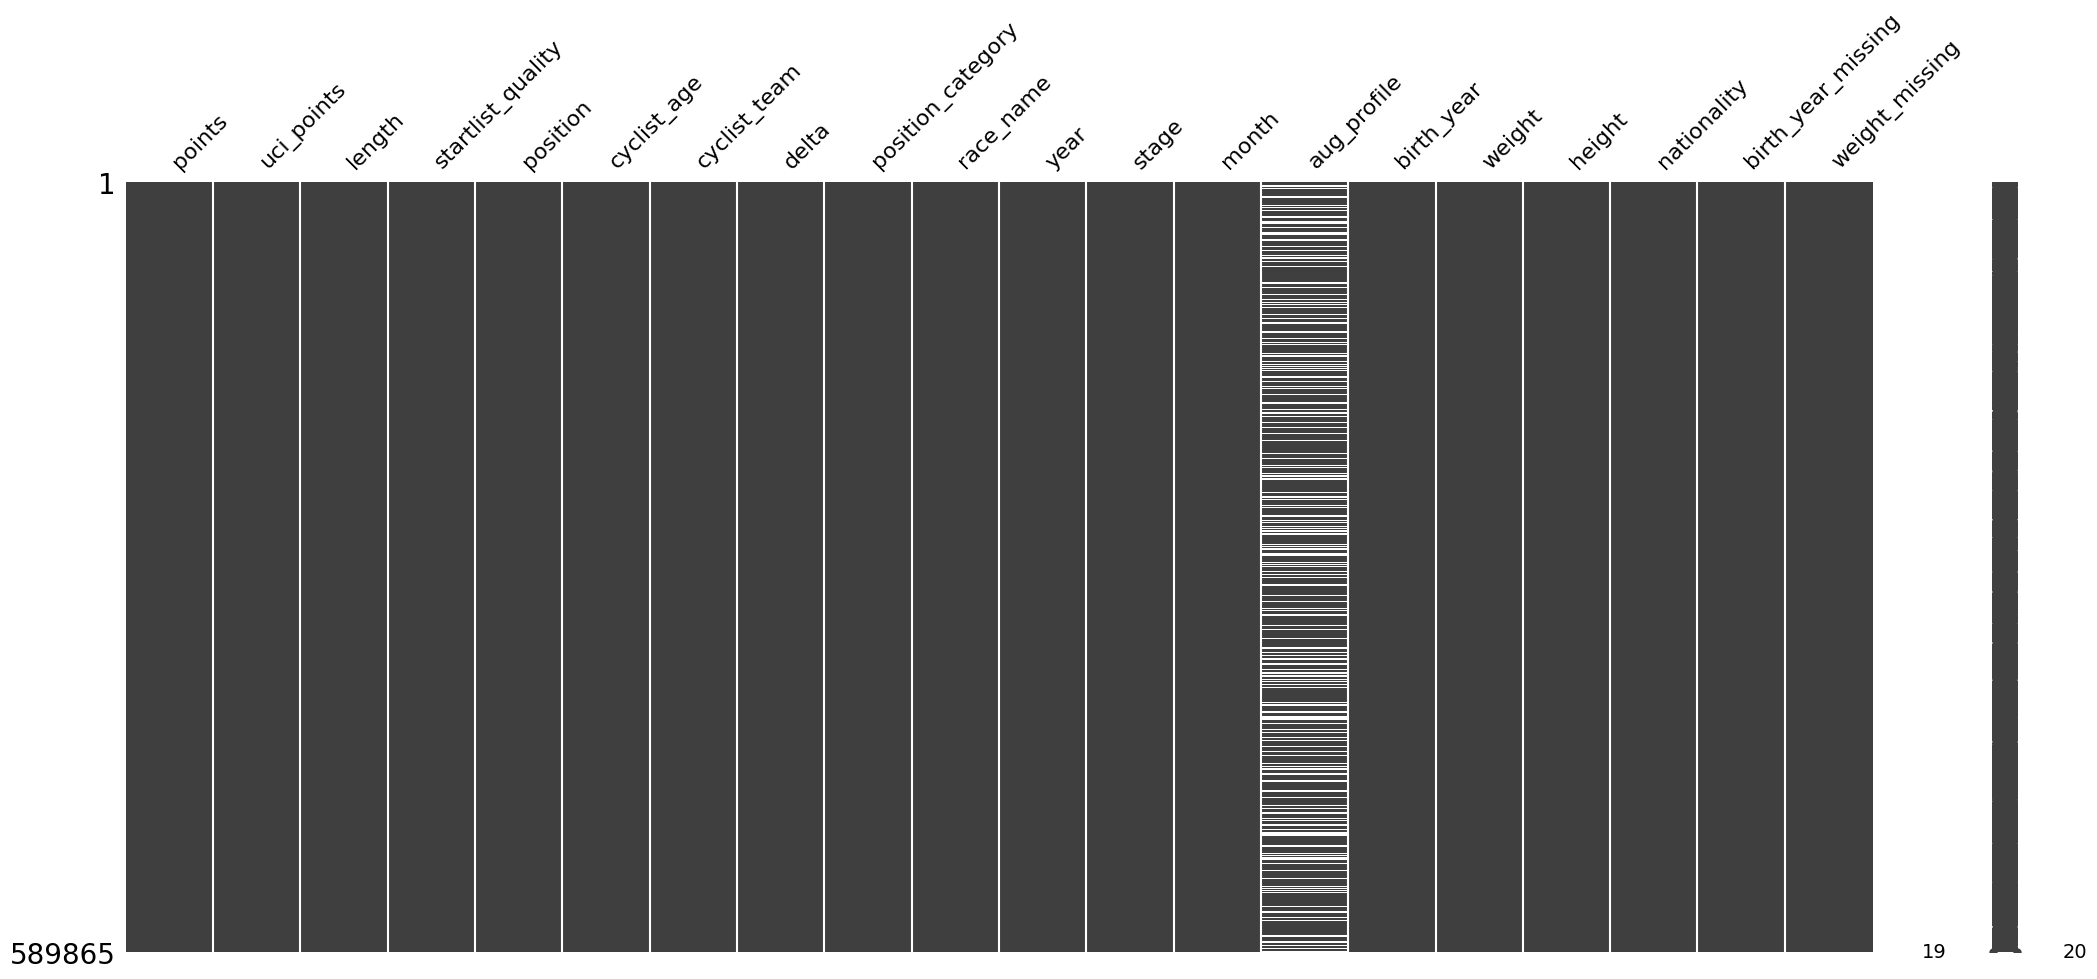

In [161]:
msno.matrix(merged_data)

In [162]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encodear 'position_category'
merged_data['position_category'] = label_encoder.fit_transform(merged_data['position_category'])

merged_data.head()

,points,uci_points,length,startlist_quality,position,cyclist_age,cyclist_team,delta,position_category,race_name,year,stage,month,aug_profile,birth_year,weight,height,nationality,birth_year_missing,weight_missing
0,100,0,162000,1241,0,22,89,0,0,20,1978,44,7,1.157872,1956.0,77.000000,180.000000,32,0,0
1,100,0,162000,1241,1,27,59,0,0,20,1978,44,7,1.157872,1951.0,68.658739,179.815145,46,0,1
2,100,0,162000,1241,2,24,91,0,0,20,1978,44,7,1.157872,1954.0,69.000000,174.000000,24,0,0
3,100,0,162000,1241,3,30,55,0,0,20,1978,44,7,1.157872,1948.0,68.658739,179.815145,7,0,1
4,100,0,162000,1241,4,27,73,0,3,20,1978,44,7,1.157872,1951.0,63.000000,172.000000,61,0,0


In [163]:
# Primero, dividimos el dataset en Train (70%)
train_data, temp_data = train_test_split(merged_data, test_size=0.30, random_state=42)

# Luego en Validation (15%) y Test (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

# Verificamos los tamaños de los conjuntos
print(f"Train set: {len(train_data)} muestras")
print(f"Validation set: {len(val_data)} muestras")
print(f"Test set: {len(test_data)} muestras")

Train set: 412905 muestras
Validation set: 88480 muestras
Test set: 88480 muestras


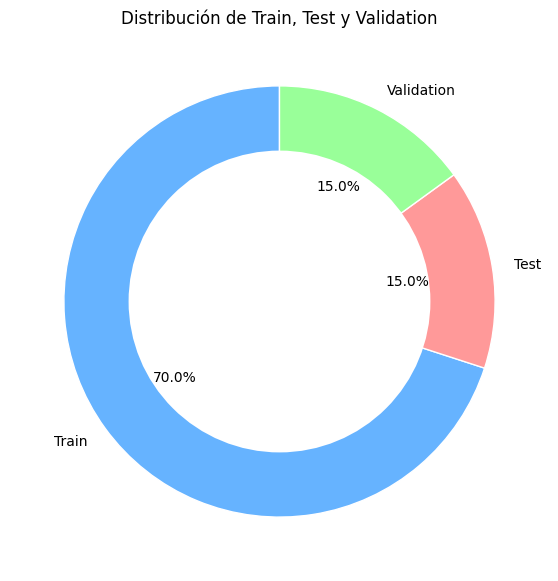

In [164]:
test_percentage = (test_data.shape[0] / merged_data.shape[0]) * 100
val_percentage = (val_data.shape[0] / merged_data.shape[0]) * 100
train_percentage = (train_data.shape[0] / merged_data.shape[0]) * 100

# Verificamos los tamaños de los conjuntos
labels = ['Train', 'Test', 'Validation']
sizes = [train_percentage, test_percentage, val_percentage]
colors = ['#66b3ff', '#ff9999', '#99ff99']  # Colores para cada segmento

# Crear la figura y el gráfico de dona
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'white'})

# Agregar un círculo en el centro para convertirlo en donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Título
plt.title("Distribución de Train, Test y Validation")
plt.show()

In [165]:
target_column = 'position_category'

X_train_data = train_data.drop(columns=[target_column])  # Remove label column
y_train_data = train_data[target_column]  # Only label column

X_test_data = test_data.drop(columns=[target_column])  # Remove label column
y_test_data = test_data[target_column]  # Only label column

X_validation_data = val_data.drop(columns=[target_column])  # Remove label column
y_validation_data = val_data[target_column]  # Only label column

# Check the shapes
print(f"X_train_data shape: {X_train_data.shape}")
print(f"y_train_data shape: {y_train_data.shape}")

X_train_data shape: (412905, 19)
y_train_data shape: (412905,)


In [166]:
scaler = StandardScaler()

X_train_data_scaled = scaler.fit_transform(X_train_data)

## convert back to DataFrame to keep column names
X_train_data_scaled = pd.DataFrame(X_train_data_scaled, columns=X_train_data.columns)

X_validation_data_scaled = scaler.transform(X_validation_data)

## convert back to DataFrame to keep column names
X_validation_data_scaled = pd.DataFrame(X_validation_data_scaled, columns=X_validation_data.columns)

X_test_data_scaled = scaler.transform(X_test_data)

## convert back to DataFrame to keep column names
X_test_data_scaled = pd.DataFrame(X_test_data_scaled, columns=X_test_data.columns)

# Check the first rows
X_train_data_scaled.head()

,points,uci_points,length,startlist_quality,position,cyclist_age,cyclist_team,delta,race_name,year,stage,month,aug_profile,birth_year,weight,height,nationality,birth_year_missing,weight_missing
0,-0.167401,0.903463,0.329143,-0.205099,1.751870,-0.639830,-0.910830,2.181437,1.073929,1.291967,1.632267,1.060529,1.681299,1.501026,1.001811,0.048811,-0.068427,-0.013657,-0.482469
1,-0.718220,-0.341381,-0.228332,-0.454629,0.201400,-0.381719,-0.448942,-0.014700,-0.894741,0.507875,0.584851,-0.956259,NaN,0.634070,-1.153620,0.755644,-1.470277,-0.013657,-0.482469
2,-0.167401,-0.420839,0.824677,-0.197219,-1.100995,0.134505,-1.669646,-0.490900,1.073929,-0.014852,0.584851,1.060529,-0.950477,-0.059494,-0.255524,-0.481313,-1.470277,-0.013657,-0.482469
3,0.199811,-0.420839,-0.073477,0.367507,-1.204360,0.134505,1.101681,-0.417188,0.458720,-2.454249,0.235712,0.556332,-1.020189,-2.486970,0.042418,0.016146,-0.587631,-0.013657,2.072670
4,-0.718220,0.373742,-0.282531,0.372760,0.015343,1.425062,-1.669646,1.097994,-1.879076,1.204846,0.759420,1.060529,1.676395,0.720766,-0.255524,0.578936,-0.587631,-0.013657,-0.482469


## 1.3 Training Models